In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
train_images = train_images[:1000]
train_labels = train_labels[:1000]

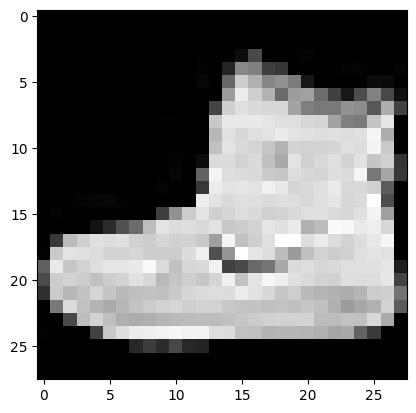

In [ ]:
plt.figure()
plt.imshow(train_images[0], cmap='gray')
plt.show()

In [ ]:
print(train_images.shape)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
print(train_images.shape)

# Normalize the images to [-1, 1] which is the range of the tanh activation
train_images = (train_images - 127.5) / 127.5

(1000, 28, 28)
(1000, 28, 28, 1)


In [ ]:
LATENT_DIM = 100
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
CHANNELS = 1 # number of channels, 1 for gray scale and 3 for color images

In [ ]:
def build_generator():
    # Define the input layer using the Functional API
    inputs = keras.Input(shape=(LATENT_DIM,))

    # prepare for reshape: FC => BN => RN layers
    x = layers.Dense(7 * 7 * 256, kernel_initializer=WEIGHT_INIT)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 1D => 3D: reshape the output of the previous layer
    x = layers.Reshape((7, 7, 256))(x)

    # upsample to 14x14: apply a transposed CONV => BN => RELU
    x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # upsample to 28x28: apply a transposed CONV => BN => RELU
    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # final layer: Conv2D with tanh activation
    outputs = layers.Conv2D(CHANNELS, (5, 5), padding="same", activation="tanh")(x)

    # return the generator model
    model = Model(inputs=inputs, outputs=outputs, name="generator")
    return model

In [ ]:
generator = build_generator()

In [ ]:
def build_discriminator(width, height, depth, alpha=0.2):
    # Define the input layer using the Functional API
    input_shape = (height, width, depth)
    inputs = keras.Input(shape=input_shape)

    # first set of CONV => BN => leaky ReLU layers
    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", kernel_initializer=WEIGHT_INIT)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=alpha)(x)

    # second set of CONV => BN => leaky ReLU layers
    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same", kernel_initializer=WEIGHT_INIT)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=alpha)(x)

    # flatten and apply dropout
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)

    # sigmoid in the last layer outputs a single value for binary classification
    outputs = layers.Dense(1, activation="sigmoid")(x)

    # return the discriminator model
    model = Model(inputs=inputs, outputs=outputs, name="discriminator")
    return model

In [ ]:
discriminator = build_discriminator(28, 28, 1)

In [ ]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Train the discriminator with both real images (label as 1) and fake images (classified as label as 0)
        with tf.GradientTape() as tape:
            # Compute discriminator loss on real images
            pred_real = self.discriminator(real_images, training=True)
            d_loss_real = self.loss_fn(tf.ones((batch_size, 1)), pred_real)

            # Compute discriminator loss on fake images
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            d_loss_fake = self.loss_fn(tf.zeros((batch_size, 1)), pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake)/2
        # Compute discriminator gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update discriminator weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Train the generator (do not update weights of the discriminator)
        # G wants D to think the fake images are real (label as 1)
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator weights
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during training
        self.seed = tf.random.normal([16, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        # random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        # generated_images = self.model.generator(random_latent_vectors)
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i])
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        plt.savefig('epoch_{:03d}.png'.format(epoch))
        plt.show()

In [ ]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)


In [ ]:
LR = 0.0002 # learning rate

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

Epoch 1/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - d_loss: 0.4684 - g_loss: 1.3244

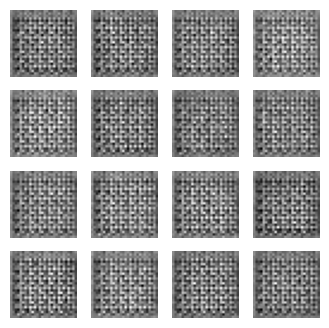

32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 688ms/step - d_loss: 0.4626 - g_loss: 1.3255
Epoch 2/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - d_loss: 0.0785 - g_loss: 1.8013

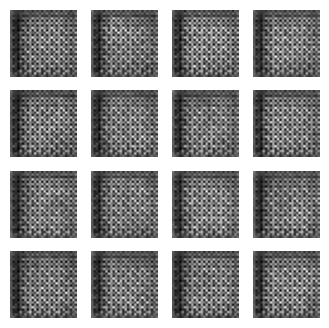

32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 657ms/step - d_loss: 0.0778 - g_loss: 1.7888


In [ ]:
dcgan.fit(train_images, epochs=2, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])

# Prediction

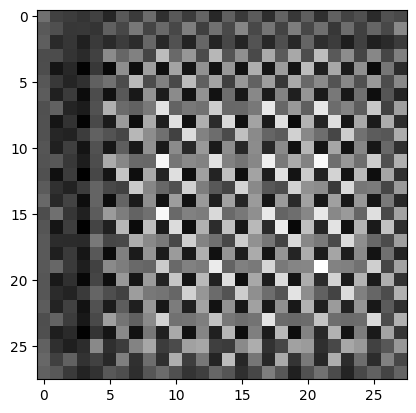

In [ ]:

noise = tf.random.normal(shape=(1, LATENT_DIM)) # Generate one image
generated_image = generator(noise) # Use the trained generator to create a fake image
generated_image = (generated_image * 127.5) + 127.5 # Denormalize the image back to the original scale
generated_image = generated_image.numpy()

# Display the generated image
plt.figure()
plt.imshow(generated_image[0], cmap='gray')
plt.show()

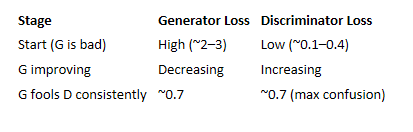